# CWRU Bearing Fault Diagnosis with Spectrogram and Scalogram Inputs

This notebook implements a Convolutional Neural Network (CNN) for fault diagnosis of rolling element bearings using the Case Western Reserve University (CWRU) dataset. The methodology is based on Verstraete et al. (2017), which uses time-frequency image representations (spectrograms via STFT and scalograms via Morlet wavelet transform) as inputs to a CNN. The CNN architecture features double convolutional layers before pooling to enhance feature expressivity.


## Overview
- **Dataset**: CWRU Bearing Data (2HP load, various fault types and sizes)
- **Input**: 96x96 pixel spectrogram images
- **Model**: CNN with three stages of double conv layers (32, 64, 128 filters), max pooling, and two dense layers
- **Training**: 5-fold stratified cross-validation with early stopping
- **Evaluation**: Accuracy, confusion matrices, and fold-wise performance plots

## Requirements
- Python libraries: tensorflow, numpy, scipy, scikit-learn, matplotlib, seaborn, pywt, skimage
- CWRU dataset files in 'CWRU_BearingData_Load_2HP' folder

Run cells sequentially to load data, preprocess, train the model, and evaluate results.

In [17]:
# Setup for Reproducibility
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Import additional libraries
import scipy.io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from skimage.transform import resize
import pywt  # For wavelet transform

## Load CWRU Bearing Data

The `ImportData` function loads the CWRU dataset files (.mat) containing vibration signals for normal and fault conditions (inner race, ball, outer race) at various fault sizes under a 2HP load. The data is stored in a list for further processing.

In [18]:
def ImportData():
    folder_path = 'CWRU_BearingData_Load_2HP'
    file_paths = [
        os.path.join(folder_path, '99.mat'),
        os.path.join(folder_path, '111.mat'),
        os.path.join(folder_path, '124.mat'),
        os.path.join(folder_path, '137.mat'),
        os.path.join(folder_path, '176.mat'),
        os.path.join(folder_path, '191.mat'),
        os.path.join(folder_path, '203.mat'),
        os.path.join(folder_path, '215.mat'),
        os.path.join(folder_path, '228.mat'),
        os.path.join(folder_path, '240.mat')
    ]
    data_keys = [
        'X099_DE_time', 'X111_DE_time', 'X124_DE_time', 'X137_DE_time',
        'X176_DE_time', 'X191_DE_time', 'X203_DE_time', 'X215_DE_time',
        'X228_DE_time', 'X240_DE_time'
    ]
    data = [scipy.io.loadmat(fp)[key] for fp, key in zip(file_paths, data_keys)]
    return data

## Time-Frequency Image Generation

The following functions generate spectrogram and scalogram images from vibration signal segments, as per Verstraete et al. (2017):
- **Spectrogram**: Uses Short-Time Fourier Transform (STFT) with a Hann window, 256-point segments, and 128-point overlap. Images are normalized and resized to 32x32 pixels.
- **Scalogram**: Uses Continuous Wavelet Transform (CWT) with the Morlet wavelet, scales 1 to 128. Magnitude is normalized and resized to 32x32 pixels.

In [19]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape=(96, 96)):

    
    """
    Calculate the spectrogram of an array data_y_vector and resize it to image_shape.
    """
    fs = 48000
    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs,
        nperseg=256,
        # noverlap=128,
        window='hann'
    )
    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)
    return sxx

def generate_scalogram_image(data_y_vector, image_shape=(96,96)):
    """
    Calculate the scalogram using Morlet wavelet and resize it to image_shape.
    """
    fs = 48000
    scales = np.arange(1, 128)  # Adjust scales for Morlet wavelet
    coef, freqs = pywt.cwt(
        data_y_vector,
        scales,
        'morl',
        sampling_period=1/fs
    )
    coef = np.abs(coef)  # Use magnitude
    coef = min_max_norm(coef)
    coef = resize(coef, image_shape, mode='constant', anti_aliasing=True)
    return coef

## Data Preprocessing

The `Sampling` function segments the vibration signals into blocks, and `DataPreparation` generates spectrogram or scalogram images for each segment. Labels are created in one-hot encoded format (`Y_CNN`) for CNN training and as integers (`Y`) for stratification. The output is a 4D array of images and corresponding labels.

In [20]:
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T
    return SplitData

def DataPreparation(Data, interval_length, samples_per_block, image_type='spectrogram'):
    """
    Prepare data by generating spectrogram or scalogram images.
    """
    X = []
    LabelPositional = []
    Label = []
    for count, data in enumerate(Data):
        SplitData = Sampling(data, interval_length, samples_per_block)
        images = []
        for segment in SplitData:
            if image_type == 'spectrogram':
                img = generate_spectrogram_image(segment)
            elif image_type == 'scalogram':
                img = generate_scalogram_image(segment)
            images.append(img)
        images = np.array(images)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        X.append(images)
        LabelPositional.append(y)
        Label.append(y1)
    X = np.concatenate(X, axis=0)
    LabelPositional = np.concatenate(LabelPositional, axis=0)
    Label = np.concatenate(Label, axis=0)
    return X, LabelPositional, Label

## CNN Model Definition

The `CNN_2D` class defines the CNN architecture as per Verstraete et al. (2017):
- Three stages, each with two convolutional layers (32, 64, 128 filters, 3x3 kernels) followed by 2x2 max pooling.
- Two dense layers (100 units each) with dropout (0.5) before the second dense layer.
- Output layer with 10 units (softmax) for 10-class classification.
- Compiled with Adam optimizer and categorical crossentropy loss.

In [21]:
class CNN_2D():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1)),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(96, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

## Main Execution

This section executes the pipeline:
- Loads and preprocesses data to generate 96x96 images (spectrogram or scalogram).
- Splits data into training (80%) and test (20%) sets with stratification.
- Performs 5-fold cross-validation with early stopping and model checkpointing.
- Saves the best model for each fold.

**Parameters**:
- `image_type`: Set to 'scalogram' or 'spectrogram' to choose input type.
- `image_shape`: 96x96 pixels for high accuracy (per Verstraete et al.).
- `kSplits`: 5 for cross-validation.
- `foldername`: Directory to save model checkpoints.

In [22]:
# Parameters
interval_length = 1600
samples_per_block = 1600
image_type = 'spectrogram'  # Change to 'spectrogram' to use spectrograms
image_shape = (96,96)
kSplits = 5
foldername = "CNN2D_results/Spectrogram-96x96-NO/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

# Load and prepare data
Data = ImportData()
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block, image_type=image_type)
Input_2D = X.reshape([-1, image_shape[0], image_shape[1], 1])
print(f"Shape of Input Data: {Input_2D.shape}")

# Train-test split
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(
    Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y
)

Shape of Input Data: (3026, 96, 96, 1)


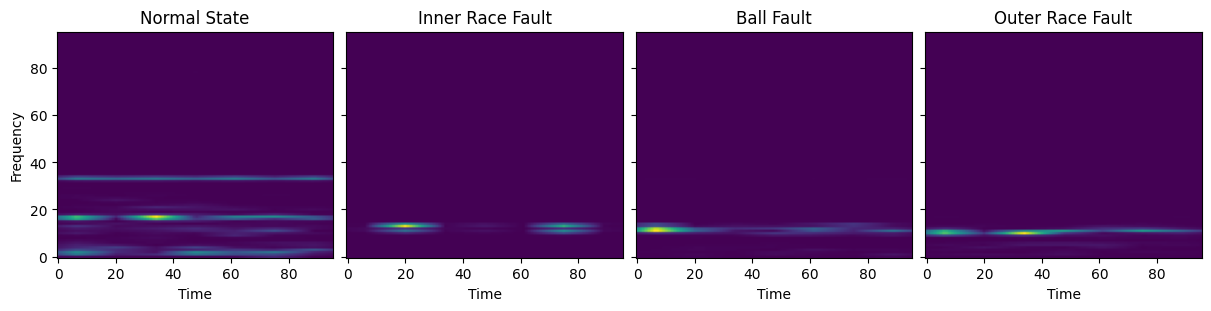

In [23]:
# Create a figure with four subplots, sharing the y-axis
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, sharey=True, figsize=(12, 3), constrained_layout=True)

# Plot Normal state spectrogram (index 0, assuming Normal samples are at the start)
plt1.set_xlabel("Time")
plt1.set_ylabel("Frequency")
plt1.set_title('Normal State')
plt1.imshow(Input_2D[0, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Inner Race fault spectrogram (index 1000, assuming Inner Race samples around this index)
plt2.set_xlabel("Time")
plt2.set_title('Inner Race Fault')
plt2.imshow(Input_2D[1000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Ball fault spectrogram (index 2000, assuming Ball fault samples around this index)
plt3.set_xlabel("Time")
plt3.set_title('Ball Fault')
plt3.imshow(Input_2D[2000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Outer Race fault spectrogram (index 2500, assuming Outer Race samples around this index)
plt4.set_xlabel("Time")
plt4.set_title('Outer Race Fault')
plt4.imshow(Input_2D[2500, :, :], aspect='auto', origin='lower', cmap='viridis')

In [24]:
# K-fold cross-validation
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True)
accuracy_train = []
accuracy_val = []
accuracy_test = []
precision_val = []
recall_val = []
f1_val = []
pred_all_val = np.zeros([len(X_2D_train), 10])
y_2D_val = np.zeros([len(X_2D_train), 10])
kfold_test_len = []
fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):
    checkpoint_filepath = foldername + f"best_model_{k}.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    Classification_2D = CNN_2D()
    history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print(f"Best model saved at: {checkpoint_filepath}")
    CNN_2D_best_model = load_model(checkpoint_filepath)
    print("Best model loaded successfully!")
    
    fl2 = fl1 + len(test)
    pred_all_val[fl1:fl2, :] = CNN_2D_best_model.predict(X_2D_train[test])
    y_2D_val[fl1:fl2, :] = y_2D_train[test]
    kfold_test_len.append(fl2 - fl1)
    fl1 = fl2

    train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train])
    accuracy_train.append(train_accuracy)
    val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test])
    accuracy_val.append(val_accuracy)
    test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test)
    accuracy_test.append(test_accuracy)

    # Calculate precision, recall, and F1 score for validation set
    y_pred_val = np.argmax(CNN_2D_best_model.predict(X_2D_train[test]), axis=1)
    y_true_val = np.argmax(y_2D_train[test], axis=1)
    precision_val.append(precision_score(y_true_val, y_pred_val, average='weighted'))
    recall_val.append(recall_score(y_true_val, y_pred_val, average='weighted'))
    f1_val.append(f1_score(y_true_val, y_pred_val, average='weighted'))


    
    k += 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-15 18:11:38.982514: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-15 18:11:38.983312: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2615 - loss: 1.9443

2025-06-15 18:12:54.954183: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-15 18:12:54.954559: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.66736, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2638 - loss: 1.9385 - val_accuracy: 0.6674 - val_loss: 0.8219
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6353 - loss: 0.8960
Epoch 2: val_accuracy improved from 0.66736 to 0.75000, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6360 - loss: 0.8943 - val_accuracy: 0.7500 - val_loss: 0.5739
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7468 - loss: 0.6322
Epoch 3: val_accuracy improved from 0.75000 to 0.79959, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7473 - loss: 0.6312 - val_accuracy: 0.7996 - val_loss: 0.5658
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8068 - loss: 0.5083
Epoch 4: val_accuracy improved from 0.79959 to 0.86157, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8071 - loss: 0.5074 - val_accuracy: 0.8616 - val_loss: 0.3643
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8391 - loss: 0.4199
Epoch 5: val_accuracy improved from 0.86157 to 0.91736, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8391 - loss: 0.4199 - val_accuracy: 0.9174 - val_loss: 0.2411
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8576 - loss: 0.3876
Epoch 6: val_accuracy improved from 0.91736 to 0.94628, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8577 - loss: 0.3868 - val_accuracy: 0.9463 - val_loss: 0.1461
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9070 - loss: 0.2507
Epoch 7: val_accuracy improved from 0.94628 to 0.95248, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9070 - loss: 0.2509 - val_accuracy: 0.9525 - val_loss: 0.1378
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9049 - loss: 0.2378
Epoch 8: val_accuracy improved from 0.95248 to 0.95661, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9050 - loss: 0.2375 - val_accuracy: 0.9566 - val_loss: 0.1182
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9209 - loss: 0.2135
Epoch 9: val_accuracy did not improve from 0.95661
61/61 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9211 - loss: 0.2134 - val_accuracy: 0.9380 - val_loss: 0.1531
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9128 - loss: 0.2289
Epoch 10: val_accuracy improved from 0.95661 to 0.97314, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9130 - loss: 0.2285 - val_accuracy: 0.9731 - val_loss: 0.0772
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9431 - loss: 0.1487
Epoch 11: val_accuracy did not improve from 0.97314
61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9431 - loss: 0.1488 - val_accuracy: 0.9545 - val_loss: 0.1168
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9472 - loss: 0.1517
Epoch 12: val_accuracy improved from 0.97314 to 0.97727, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9472 - loss: 0.1516 - val_accuracy: 0.9773 - val_loss: 0.0649
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9605 - loss: 0.1147
Epoch 13: val_accuracy improved from 0.97727 to 0.98554, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9604 - loss: 0.1149 - val_accuracy: 0.9855 - val_loss: 0.0398
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9647 - loss: 0.1028
Epoch 14: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9646 - loss: 0.1030 - val_accuracy: 0.9773 - val_loss: 0.0632
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9503 - loss: 0.1406
Epoch 15: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9504 - loss: 0.1405 - val_accuracy: 0.9525 - val_loss: 0.1051
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9498 - loss: 0.1394
Epoch 16: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9499 - loss: 0.1392 - val_accuracy: 0.9669 - val_loss: 0.0932
Epoch 17/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9610 - loss: 0.1029
Epoch 17: val_accuracy improved from 0.98554

61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9610 - loss: 0.1027 - val_accuracy: 0.9876 - val_loss: 0.0451
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9575 - loss: 0.1237
Epoch 18: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9574 - loss: 0.1239 - val_accuracy: 0.9835 - val_loss: 0.0476
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9639 - loss: 0.1052
Epoch 19: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9638 - loss: 0.1055 - val_accuracy: 0.9855 - val_loss: 0.0380
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9750 - loss: 0.0783
Epoch 20: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9750 - loss: 0.0783 - val_accuracy: 0.9793 - val_loss: 0.0614
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9684 - loss: 0.0886
Epoch 21: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9661 - loss: 0.1227 - val_accuracy: 0.9917 - val_loss: 0.0227
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9793 - loss: 0.0602
Epoch 26: val_accuracy did not improve from 0.99174
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9793 - loss: 0.0603 - val_accuracy: 0.9876 - val_loss: 0.0459
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9813 - loss: 0.0622
Epoch 27: val_accuracy did not improve from 0.99174
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9812 - loss: 0.0623 - val_accuracy: 0.9814 - val_loss: 0.0542
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9758 - loss: 0.0612
Epoch 28: val_accuracy improved from 0.99174 to 0.99380, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_1.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9758 - loss: 0.0613 - val_accuracy: 0.9938 - val_loss: 0.0168
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9818 - loss: 0.0562
Epoch 29: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9818 - loss: 0.0562 - val_accuracy: 0.9731 - val_loss: 0.0822
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9850 - loss: 0.0450
Epoch 30: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9849 - loss: 0.0450 - val_accuracy: 0.9897 - val_loss: 0.0289
Epoch 31/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9837 - loss: 0.0393
Epoch 31: val_accuracy did not improve from 0.99380
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9837 - loss: 0.0394 - val_accuracy: 0.9793 - val_loss: 0.0796
Epoch 32/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9816 - loss: 0.0546
Epoch 32: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9788 - loss: 0.0604 - val_accuracy: 0.9959 - val_loss: 0.0167
Epoch 44/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9840 - loss: 0.0434
Epoch 44: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9840 - loss: 0.0434 - val_accuracy: 0.9835 - val_loss: 0.0530
Epoch 45/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9950 - loss: 0.0204
Epoch 45: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9950 - loss: 0.0205 - val_accuracy: 0.9649 - val_loss: 0.1620
Epoch 46/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9722 - loss: 0.0735
Epoch 46: val_accuracy did not improve from 0.99587
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9724 - loss: 0.0732 - val_accuracy: 0.9835 - val_loss: 0.0631
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9852 - loss: 0.0496
Epoch 47: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9932 - loss: 0.0188 - val_accuracy: 0.9979 - val_loss: 0.0132
Epoch 92/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9984 - loss: 0.0072
Epoch 92: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9984 - loss: 0.0072 - val_accuracy: 0.9917 - val_loss: 0.0185
Epoch 93/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9980 - loss: 0.0059
Epoch 93: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.9917 - val_loss: 0.0209
Epoch 94/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9942 - loss: 0.0141
Epoch 94: val_accuracy did not improve from 0.99793
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9942 - loss: 0.0142 - val_accuracy: 0.9897 - val_loss: 0.0335
Epoch 95/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9962 - loss: 0.0126
Epoch 95: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-15 21:28:47.809611: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-15 21:28:47.811202: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step


2025-06-15 21:28:54.777504: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-15 21:28:54.777887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 390ms/step - accuracy: 1.0000 - loss: 2.7822e-04


2025-06-15 21:29:18.979609: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-15 21:29:18.979943: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.9937 - loss: 0.0287


2025-06-15 21:29:25.242285: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-15 21:29:25.242668: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 402ms/step - accuracy: 0.9871 - loss: 0.0667


2025-06-15 21:29:32.976033: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-15 21:29:32.976345: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step
Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-15 21:29:39.189217: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2237 - loss: 2.0501

2025-06-15 21:30:57.383664: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-15 21:30:57.383963: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.70041, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2255 - loss: 2.0451 - val_accuracy: 0.7004 - val_loss: 0.9363
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5802 - loss: 1.0590
Epoch 2: val_accuracy improved from 0.70041 to 0.83884, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5811 - loss: 1.0568 - val_accuracy: 0.8388 - val_loss: 0.5197
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7116 - loss: 0.7319
Epoch 3: val_accuracy improved from 0.83884 to 0.86570, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7119 - loss: 0.7309 - val_accuracy: 0.8657 - val_loss: 0.3326
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7804 - loss: 0.6072
Epoch 4: val_accuracy improved from 0.86570 to 0.92355, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7805 - loss: 0.6063 - val_accuracy: 0.9236 - val_loss: 0.2357
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8223 - loss: 0.4494
Epoch 5: val_accuracy did not improve from 0.92355
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8225 - loss: 0.4489 - val_accuracy: 0.9050 - val_loss: 0.2142
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8434 - loss: 0.4177
Epoch 6: val_accuracy did not improve from 0.92355
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8437 - loss: 0.4170 - val_accuracy: 0.9070 - val_loss: 0.2285
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8536 - loss: 0.3512
Epoch 7: val_accuracy improved from 0.92355 to 0.95248, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8540 - loss: 0.3505 - val_accuracy: 0.9525 - val_loss: 0.1194
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9116 - loss: 0.2270
Epoch 8: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9116 - loss: 0.2270 - val_accuracy: 0.9525 - val_loss: 0.1154
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8846 - loss: 0.2949
Epoch 9: val_accuracy did not improve from 0.95248
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8849 - loss: 0.2942 - val_accuracy: 0.9442 - val_loss: 0.1449
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9184 - loss: 0.2251
Epoch 10: val_accuracy improved from 0.95248 to 0.97314, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9186 - loss: 0.2249 - val_accuracy: 0.9731 - val_loss: 0.0696
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9421 - loss: 0.1607
Epoch 11: val_accuracy improved from 0.97314 to 0.97934, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9420 - loss: 0.1608 - val_accuracy: 0.9793 - val_loss: 0.0792
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9433 - loss: 0.1510
Epoch 12: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9431 - loss: 0.1513 - val_accuracy: 0.9690 - val_loss: 0.0898
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9370 - loss: 0.1870
Epoch 13: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9370 - loss: 0.1869 - val_accuracy: 0.9793 - val_loss: 0.0948
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9418 - loss: 0.1536
Epoch 14: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9419 - loss: 0.1534 - val_accuracy: 0.9773 - val_loss: 0.0701
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9518 - loss: 0.1653
Epoch 15: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9521 - loss: 0.1422 - val_accuracy: 0.9814 - val_loss: 0.0763
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9549 - loss: 0.1142
Epoch 24: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9548 - loss: 0.1146 - val_accuracy: 0.9566 - val_loss: 0.1196
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9439 - loss: 0.1633
Epoch 25: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9440 - loss: 0.1630 - val_accuracy: 0.9669 - val_loss: 0.0757
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9574 - loss: 0.1154
Epoch 26: val_accuracy improved from 0.98140 to 0.98347, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9575 - loss: 0.1151 - val_accuracy: 0.9835 - val_loss: 0.0673
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9612 - loss: 0.1144
Epoch 27: val_accuracy improved from 0.98347 to 0.98554, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_2.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9612 - loss: 0.1144 - val_accuracy: 0.9855 - val_loss: 0.0751
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9586 - loss: 0.1174
Epoch 28: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9588 - loss: 0.1171 - val_accuracy: 0.9793 - val_loss: 0.0850
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9695 - loss: 0.0888
Epoch 29: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9695 - loss: 0.0888 - val_accuracy: 0.9814 - val_loss: 0.1004
Epoch 30/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9771 - loss: 0.0957
Epoch 30: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9771 - loss: 0.0953 - val_accuracy: 0.9731 - val_loss: 0.0877
Epoch 31/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9694 - loss: 0.0936
Epoch 31: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9935 - loss: 0.0184 - val_accuracy: 0.9876 - val_loss: 0.1061
Epoch 66/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9949 - loss: 0.0144
Epoch 66: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9948 - loss: 0.0145 - val_accuracy: 0.9855 - val_loss: 0.1028
Epoch 67/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9886 - loss: 0.0390
Epoch 67: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9886 - loss: 0.0392 - val_accuracy: 0.9711 - val_loss: 0.1114
Epoch 68/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9896 - loss: 0.0311
Epoch 68: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9895 - loss: 0.0312 - val_accuracy: 0.9793 - val_loss: 0.1264
Epoch 69/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9880 - loss: 0.0421
Epoch 69: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9814 - loss: 0.0467 - val_accuracy: 0.9897 - val_loss: 0.0631
Epoch 76/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9847 - loss: 0.0464
Epoch 76: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9848 - loss: 0.0462 - val_accuracy: 0.9773 - val_loss: 0.1347
Epoch 77/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9752 - loss: 0.0831
Epoch 77: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9752 - loss: 0.0833 - val_accuracy: 0.9731 - val_loss: 0.1295
Epoch 78/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9795 - loss: 0.0594
Epoch 78: val_accuracy did not improve from 0.98967
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9796 - loss: 0.0592 - val_accuracy: 0.9773 - val_loss: 0.1187
Epoch 79/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9855 - loss: 0.0430
Epoch 79: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-16 00:22:12.170407: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 00:22:12.173028: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step


2025-06-16 00:22:18.818703: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 00:22:18.819103: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 396ms/step - accuracy: 0.9975 - loss: 0.0055


2025-06-16 00:22:43.286009: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 00:22:43.286338: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 365ms/step - accuracy: 0.9929 - loss: 0.0500


2025-06-16 00:22:49.335874: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 00:22:49.336154: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.9814 - loss: 0.0508


2025-06-16 00:22:57.321390: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 00:22:57.321801: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-16 00:23:04.226770: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 00:23:04.227106: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2772 - loss: 2.0085

2025-06-16 00:24:23.560687: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 00:24:23.560981: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.73554, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2788 - loss: 2.0029 - val_accuracy: 0.7355 - val_loss: 0.6857
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6464 - loss: 0.8983
Epoch 2: val_accuracy improved from 0.73554 to 0.82438, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6469 - loss: 0.8972 - val_accuracy: 0.8244 - val_loss: 0.4439
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7598 - loss: 0.6507
Epoch 3: val_accuracy did not improve from 0.82438
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7600 - loss: 0.6498 - val_accuracy: 0.8244 - val_loss: 0.5103
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8165 - loss: 0.4801
Epoch 4: val_accuracy improved from 0.82438 to 0.89463, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8168 - loss: 0.4793 - val_accuracy: 0.8946 - val_loss: 0.2797
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8739 - loss: 0.3399
Epoch 5: val_accuracy did not improve from 0.89463
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8738 - loss: 0.3403 - val_accuracy: 0.8409 - val_loss: 0.4036
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8771 - loss: 0.3540
Epoch 6: val_accuracy improved from 0.89463 to 0.90702, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8774 - loss: 0.3531 - val_accuracy: 0.9070 - val_loss: 0.3065
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8856 - loss: 0.3073
Epoch 7: val_accuracy improved from 0.90702 to 0.92975, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8859 - loss: 0.3066 - val_accuracy: 0.9298 - val_loss: 0.1949
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9249 - loss: 0.2043
Epoch 8: val_accuracy improved from 0.92975 to 0.96074, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9249 - loss: 0.2041 - val_accuracy: 0.9607 - val_loss: 0.1296
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9424 - loss: 0.1545
Epoch 9: val_accuracy improved from 0.96074 to 0.96488, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9425 - loss: 0.1545 - val_accuracy: 0.9649 - val_loss: 0.0912
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9481 - loss: 0.1538
Epoch 10: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9481 - loss: 0.1538 - val_accuracy: 0.9421 - val_loss: 0.1538
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9419 - loss: 0.1533
Epoch 11: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9420 - loss: 0.1532 - val_accuracy: 0.9318 - val_loss: 0.1889
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9652 - loss: 0.1157
Epoch 12: val_accuracy did not improve from 0.96488
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9652 - loss: 0.1157 - val_accuracy: 0.9504 - val_loss: 0.2068
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9580 - loss: 0.1029
Epoch 13: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9634 - loss: 0.1159 - val_accuracy: 0.9669 - val_loss: 0.0986
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9744 - loss: 0.0854
Epoch 18: val_accuracy did not improve from 0.96694
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9744 - loss: 0.0854 - val_accuracy: 0.9298 - val_loss: 0.2570
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9655 - loss: 0.0858
Epoch 19: val_accuracy improved from 0.96694 to 0.97107, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_3.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9656 - loss: 0.0856 - val_accuracy: 0.9711 - val_loss: 0.1025
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9714 - loss: 0.0842
Epoch 20: val_accuracy did not improve from 0.97107
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9714 - loss: 0.0843 - val_accuracy: 0.9649 - val_loss: 0.1057
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9726 - loss: 0.0687
Epoch 21: val_accuracy did not improve from 0.97107
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9726 - loss: 0.0688 - val_accuracy: 0.9587 - val_loss: 0.1015
Epoch 22/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9704 - loss: 0.0813
Epoch 22: val_accuracy did not improve from 0.97107
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9703 - loss: 0.0817 - val_accuracy: 0.9483 - val_loss: 0.1539
Epoch 23/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9770 - loss: 0.0692
Epoch 23: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9612 - loss: 0.1229 - val_accuracy: 0.9752 - val_loss: 0.0692
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9890 - loss: 0.0345
Epoch 26: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9889 - loss: 0.0349 - val_accuracy: 0.9711 - val_loss: 0.0817
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9751 - loss: 0.0800
Epoch 27: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9751 - loss: 0.0798 - val_accuracy: 0.9731 - val_loss: 0.0949
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9785 - loss: 0.0458
Epoch 28: val_accuracy did not improve from 0.97521
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9786 - loss: 0.0461 - val_accuracy: 0.9504 - val_loss: 0.1565
Epoch 29/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9609 - loss: 0.0967
Epoch 29: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9809 - loss: 0.0554 - val_accuracy: 0.9793 - val_loss: 0.0760
Epoch 58/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9967 - loss: 0.0122
Epoch 58: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9967 - loss: 0.0123 - val_accuracy: 0.9731 - val_loss: 0.0988
Epoch 59/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9909 - loss: 0.0293
Epoch 59: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9909 - loss: 0.0292 - val_accuracy: 0.9773 - val_loss: 0.1027
Epoch 60/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9883 - loss: 0.0338
Epoch 60: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9883 - loss: 0.0337 - val_accuracy: 0.9711 - val_loss: 0.1560
Epoch 61/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9911 - loss: 0.0351
Epoch 61: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-16 02:50:30.912043: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 02:50:30.912885: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step


2025-06-16 02:50:37.885154: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 02:50:37.885481: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 1.0000 - loss: 0.0012


2025-06-16 02:51:01.658304: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 02:51:01.658608: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.9776 - loss: 0.0745


2025-06-16 02:51:07.701120: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 02:51:07.701446: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.9876 - loss: 0.0701


2025-06-16 02:51:15.087941: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 02:51:15.088218: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step
Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-16 02:51:21.256596: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2355 - loss: 2.0102

2025-06-16 02:52:40.396060: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 02:52:40.396366: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.61983, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2374 - loss: 2.0053 - val_accuracy: 0.6198 - val_loss: 0.9716
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6012 - loss: 1.0245
Epoch 2: val_accuracy improved from 0.61983 to 0.80165, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6018 - loss: 1.0228 - val_accuracy: 0.8017 - val_loss: 0.5488
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7168 - loss: 0.6619
Epoch 3: val_accuracy improved from 0.80165 to 0.84917, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7170 - loss: 0.6617 - val_accuracy: 0.8492 - val_loss: 0.3977
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7873 - loss: 0.5248
Epoch 4: val_accuracy improved from 0.84917 to 0.87603, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7874 - loss: 0.5245 - val_accuracy: 0.8760 - val_loss: 0.3279
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8266 - loss: 0.4327
Epoch 5: val_accuracy improved from 0.87603 to 0.93182, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8268 - loss: 0.4325 - val_accuracy: 0.9318 - val_loss: 0.1818
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8652 - loss: 0.3767
Epoch 6: val_accuracy did not improve from 0.93182
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8649 - loss: 0.3772 - val_accuracy: 0.9029 - val_loss: 0.2847
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8610 - loss: 0.3848
Epoch 7: val_accuracy improved from 0.93182 to 0.93802, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8612 - loss: 0.3844 - val_accuracy: 0.9380 - val_loss: 0.1875
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9152 - loss: 0.2507
Epoch 8: val_accuracy did not improve from 0.93802
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9152 - loss: 0.2506 - val_accuracy: 0.9112 - val_loss: 0.2125
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8877 - loss: 0.2826
Epoch 9: val_accuracy improved from 0.93802 to 0.94421, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8879 - loss: 0.2823 - val_accuracy: 0.9442 - val_loss: 0.1760
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9346 - loss: 0.1861
Epoch 10: val_accuracy improved from 0.94421 to 0.94628, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9343 - loss: 0.1866 - val_accuracy: 0.9463 - val_loss: 0.1240
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9307 - loss: 0.1851
Epoch 11: val_accuracy did not improve from 0.94628
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9306 - loss: 0.1855 - val_accuracy: 0.9360 - val_loss: 0.1559
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9376 - loss: 0.1797
Epoch 12: val_accuracy improved from 0.94628 to 0.97314, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9375 - loss: 0.1801 - val_accuracy: 0.9731 - val_loss: 0.0927
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9522 - loss: 0.1428
Epoch 13: val_accuracy did not improve from 0.97314
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9520 - loss: 0.1431 - val_accuracy: 0.9607 - val_loss: 0.1417
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9239 - loss: 0.1772
Epoch 14: val_accuracy did not improve from 0.97314
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9240 - loss: 0.1770 - val_accuracy: 0.9607 - val_loss: 0.1102
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9484 - loss: 0.1417
Epoch 15: val_accuracy did not improve from 0.97314
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9483 - loss: 0.1420 - val_accuracy: 0.9669 - val_loss: 0.1060
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9624 - loss: 0.1085
Epoch 16: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9690 - loss: 0.0878 - val_accuracy: 0.9773 - val_loss: 0.0598
Epoch 24/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9768 - loss: 0.0554
Epoch 24: val_accuracy improved from 0.97727 to 0.97934, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_4.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9767 - loss: 0.0557 - val_accuracy: 0.9793 - val_loss: 0.0584
Epoch 25/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9685 - loss: 0.0960
Epoch 25: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9685 - loss: 0.0963 - val_accuracy: 0.9773 - val_loss: 0.0740
Epoch 26/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9507 - loss: 0.1497
Epoch 26: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9508 - loss: 0.1492 - val_accuracy: 0.9525 - val_loss: 0.1595
Epoch 27/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9767 - loss: 0.0680
Epoch 27: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9766 - loss: 0.0682 - val_accuracy: 0.9380 - val_loss: 0.1942
Epoch 28/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9432 - loss: 0.1730
Epoch 28: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9679 - loss: 0.1145 - val_accuracy: 0.9814 - val_loss: 0.0723
Epoch 36/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9856 - loss: 0.0414
Epoch 36: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9855 - loss: 0.0416 - val_accuracy: 0.9649 - val_loss: 0.1112
Epoch 37/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9591 - loss: 0.1202
Epoch 37: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9592 - loss: 0.1200 - val_accuracy: 0.9628 - val_loss: 0.1197
Epoch 38/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9738 - loss: 0.0733
Epoch 38: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9737 - loss: 0.0734 - val_accuracy: 0.9731 - val_loss: 0.0824
Epoch 39/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9852 - loss: 0.0438
Epoch 39: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9902 - loss: 0.0277 - val_accuracy: 0.9855 - val_loss: 0.0645
Epoch 44/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9859 - loss: 0.0431
Epoch 44: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9858 - loss: 0.0431 - val_accuracy: 0.9773 - val_loss: 0.1125
Epoch 45/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9883 - loss: 0.0442
Epoch 45: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9883 - loss: 0.0442 - val_accuracy: 0.9773 - val_loss: 0.0865
Epoch 46/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9891 - loss: 0.0360
Epoch 46: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9889 - loss: 0.0365 - val_accuracy: 0.9318 - val_loss: 0.2426
Epoch 47/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9570 - loss: 0.1265
Epoch 47: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9785 - loss: 0.0505 - val_accuracy: 0.9876 - val_loss: 0.0591
Epoch 55/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9825 - loss: 0.0434
Epoch 55: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9825 - loss: 0.0436 - val_accuracy: 0.9731 - val_loss: 0.0963
Epoch 56/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9772 - loss: 0.0742
Epoch 56: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9773 - loss: 0.0741 - val_accuracy: 0.9752 - val_loss: 0.0876
Epoch 57/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9827 - loss: 0.0484
Epoch 57: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9827 - loss: 0.0484 - val_accuracy: 0.9855 - val_loss: 0.0385
Epoch 58/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9840 - loss: 0.0380
Epoch 58: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-16 05:11:50.457054: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 05:11:50.459770: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step


2025-06-16 05:11:56.926042: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 05:11:56.926348: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9970 - loss: 0.0075


2025-06-16 05:12:19.630924: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 05:12:19.631200: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.9857 - loss: 0.0739


2025-06-16 05:12:25.525710: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 05:12:25.525962: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.9829 - loss: 0.0692


2025-06-16 05:12:32.583636: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 05:12:32.583875: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-16 05:12:38.935894: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 05:12:38.936231: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2259 - loss: 2.0329

2025-06-16 05:13:52.106800: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 05:13:52.107175: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.60331, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2278 - loss: 2.0276 - val_accuracy: 0.6033 - val_loss: 0.9496
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6040 - loss: 0.9642
Epoch 2: val_accuracy improved from 0.60331 to 0.74793, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6046 - loss: 0.9629 - val_accuracy: 0.7479 - val_loss: 0.6491
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7128 - loss: 0.6799
Epoch 3: val_accuracy improved from 0.74793 to 0.82645, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7132 - loss: 0.6794 - val_accuracy: 0.8264 - val_loss: 0.4380
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7918 - loss: 0.5062
Epoch 4: val_accuracy improved from 0.82645 to 0.87397, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7918 - loss: 0.5060 - val_accuracy: 0.8740 - val_loss: 0.3178
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8221 - loss: 0.4673
Epoch 5: val_accuracy improved from 0.87397 to 0.89050, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8220 - loss: 0.4674 - val_accuracy: 0.8905 - val_loss: 0.3047
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8497 - loss: 0.3840
Epoch 6: val_accuracy improved from 0.89050 to 0.89876, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8496 - loss: 0.3841 - val_accuracy: 0.8988 - val_loss: 0.2584
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8826 - loss: 0.3228
Epoch 7: val_accuracy improved from 0.89876 to 0.91322, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8826 - loss: 0.3229 - val_accuracy: 0.9132 - val_loss: 0.2646
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8894 - loss: 0.3008
Epoch 8: val_accuracy improved from 0.91322 to 0.95248, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8893 - loss: 0.3010 - val_accuracy: 0.9525 - val_loss: 0.1767
Epoch 9/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8994 - loss: 0.2904
Epoch 9: val_accuracy improved from 0.95248 to 0.95868, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8993 - loss: 0.2904 - val_accuracy: 0.9587 - val_loss: 0.1612
Epoch 10/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9234 - loss: 0.2078
Epoch 10: val_accuracy did not improve from 0.95868
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9232 - loss: 0.2080 - val_accuracy: 0.9483 - val_loss: 0.1495
Epoch 11/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9305 - loss: 0.1891
Epoch 11: val_accuracy improved from 0.95868 to 0.96074, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9305 - loss: 0.1892 - val_accuracy: 0.9607 - val_loss: 0.1462
Epoch 12/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9256 - loss: 0.2186
Epoch 12: val_accuracy improved from 0.96074 to 0.96901, saving model to CNN2D_results/Spectrogram-96x96-NO/best_model_5.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9256 - loss: 0.2187 - val_accuracy: 0.9690 - val_loss: 0.1318
Epoch 13/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9480 - loss: 0.1600
Epoch 13: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9480 - loss: 0.1599 - val_accuracy: 0.9525 - val_loss: 0.1775
Epoch 14/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9429 - loss: 0.1736
Epoch 14: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9428 - loss: 0.1738 - val_accuracy: 0.9504 - val_loss: 0.1641
Epoch 15/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9313 - loss: 0.1912
Epoch 15: val_accuracy did not improve from 0.96901
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9313 - loss: 0.1913 - val_accuracy: 0.9339 - val_loss: 0.2323
Epoch 16/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9461 - loss: 0.1734
Epoch 16: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9483 - loss: 0.1480 - val_accuracy: 0.9793 - val_loss: 0.1134
Epoch 18/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9592 - loss: 0.1042
Epoch 18: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9590 - loss: 0.1048 - val_accuracy: 0.9566 - val_loss: 0.1513
Epoch 19/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9616 - loss: 0.1010
Epoch 19: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9616 - loss: 0.1010 - val_accuracy: 0.9566 - val_loss: 0.1621
Epoch 20/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9623 - loss: 0.1149
Epoch 20: val_accuracy did not improve from 0.97934
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9623 - loss: 0.1152 - val_accuracy: 0.9690 - val_loss: 0.1242
Epoch 21/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9652 - loss: 0.0799
Epoch 21: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9785 - loss: 0.0672 - val_accuracy: 0.9814 - val_loss: 0.1130
Epoch 32/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9691 - loss: 0.0785
Epoch 32: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9691 - loss: 0.0787 - val_accuracy: 0.9773 - val_loss: 0.1156
Epoch 33/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9800 - loss: 0.0524
Epoch 33: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9799 - loss: 0.0527 - val_accuracy: 0.9731 - val_loss: 0.1142
Epoch 34/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9823 - loss: 0.0477
Epoch 34: val_accuracy did not improve from 0.98140
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9822 - loss: 0.0479 - val_accuracy: 0.9814 - val_loss: 0.0746
Epoch 35/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9727 - loss: 0.0672
Epoch 35: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9902 - loss: 0.0286 - val_accuracy: 0.9855 - val_loss: 0.0743
Epoch 51/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9758 - loss: 0.0825
Epoch 51: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9759 - loss: 0.0822 - val_accuracy: 0.9773 - val_loss: 0.0765
Epoch 52/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9867 - loss: 0.0413
Epoch 52: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9867 - loss: 0.0412 - val_accuracy: 0.9814 - val_loss: 0.0852
Epoch 53/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9893 - loss: 0.0396
Epoch 53: val_accuracy did not improve from 0.98554
61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9893 - loss: 0.0395 - val_accuracy: 0.9793 - val_loss: 0.0955
Epoch 54/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9828 - loss: 0.0458
Epoch 54: val_accuracy did not improve from 

61/61 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9925 - loss: 0.0233 - val_accuracy: 0.9876 - val_loss: 0.0760
Epoch 76/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9919 - loss: 0.0224
Epoch 76: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9919 - loss: 0.0224 - val_accuracy: 0.9773 - val_loss: 0.1125
Epoch 77/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9977 - loss: 0.0080
Epoch 77: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9976 - loss: 0.0082 - val_accuracy: 0.9731 - val_loss: 0.1021
Epoch 78/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9880 - loss: 0.0371
Epoch 78: val_accuracy did not improve from 0.98760
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9879 - loss: 0.0373 - val_accuracy: 0.9835 - val_loss: 0.0846
Epoch 79/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9832 - loss: 0.0441
Epoch 79: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-16 07:53:54.257902: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 07:53:54.258887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 353ms/step


2025-06-16 07:54:00.643559: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 07:54:00.643847: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.9999 - loss: 0.0031


2025-06-16 07:54:23.494740: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 07:54:23.495026: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.9926 - loss: 0.0459


2025-06-16 07:54:29.278746: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 07:54:29.279056: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.9859 - loss: 0.0427


2025-06-16 07:54:36.454847: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 07:54:36.455138: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step


## Model Evaluation

Evaluate the trained model by computing average accuracies across folds for training, validation, and test sets. Visualize performance with confusion matrices for train and test sets, and bar plots for fold-wise and train vs. test accuracies.

CNN 2D train accuracy = 99.9276852607727
CNN 2D validation accuracy = 98.84297490119934
CNN 2D test accuracy = 98.31683158874512
precision val[0.9979760499241018, 0.989708106207139, 0.9794135396817423, 0.9877614085519224, 0.987728959352336]
recall_val[0.9979338842975206, 0.9896694214876033, 0.9793388429752066, 0.987603305785124, 0.987603305785124]
f1 val[0.9979338842975206, 0.9896681033914614, 0.979335767417542, 0.9875997172211597, 0.9876017310471727]


2025-06-16 07:54:42.382613: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 07:54:42.382909: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step
CNN 2D Validation Precision = 98.85%
CNN 2D Validation Recall = 98.84%
CNN 2D Validation F1 Score = 98.84%
CNN 2D Test Precision = 98.53%
CNN 2D Test Recall = 98.51%
CNN 2D Test F1 Score = 98.51%


2025-06-16 07:54:49.929944: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 07:54:49.930227: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 371ms/step


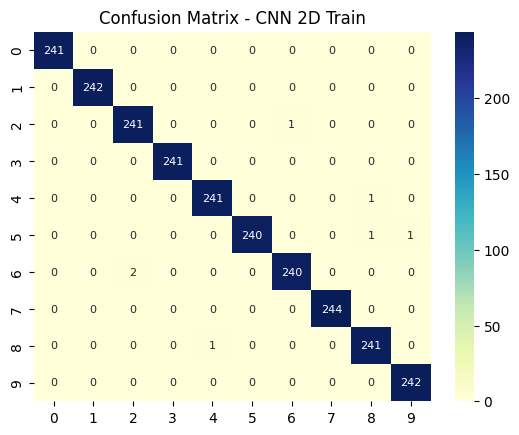

2025-06-16 07:55:18.379656: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 07:55:18.379950: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step


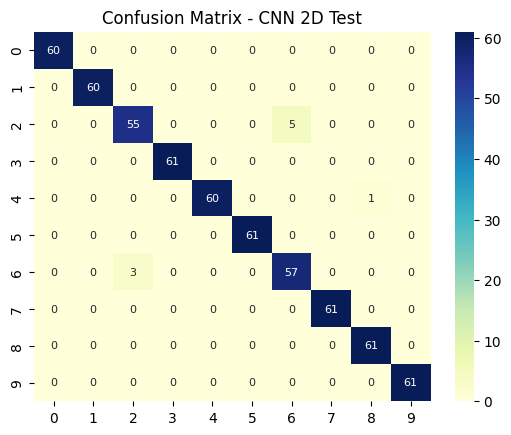

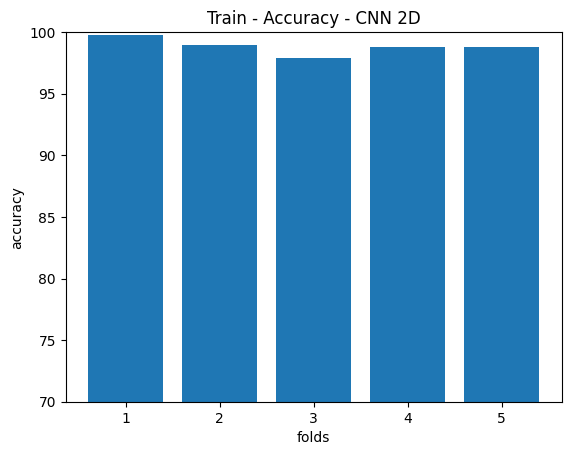

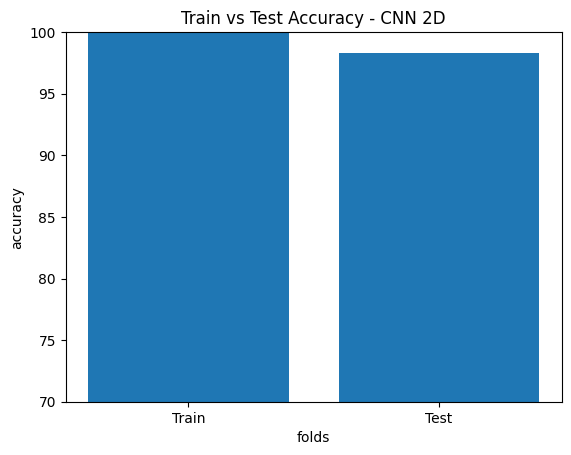

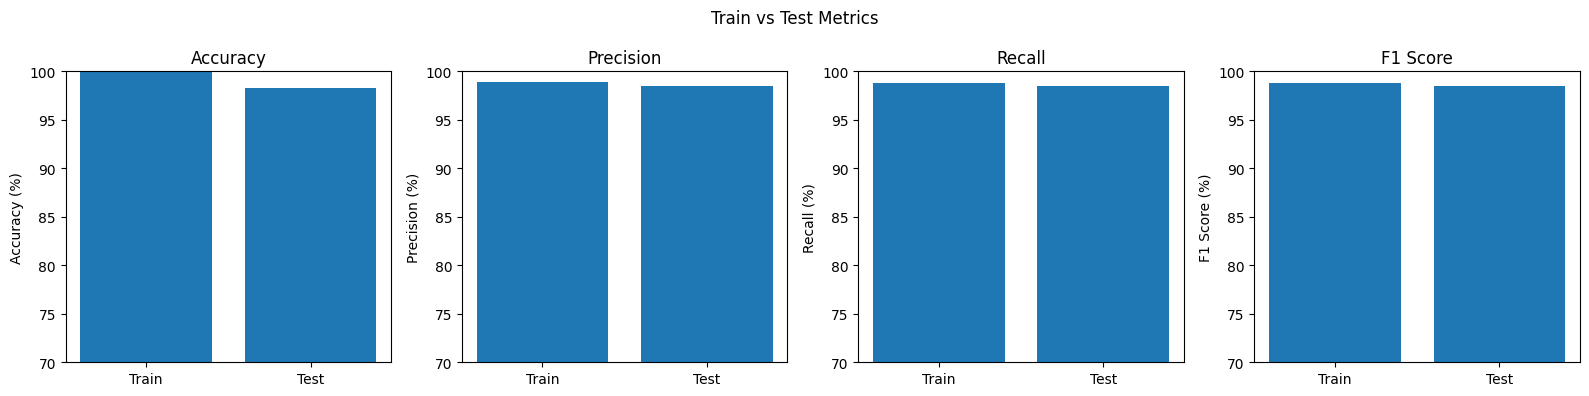

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

CNN_2D_train_accuracy = np.average(accuracy_train) * 100
print(f'CNN 2D train accuracy = {CNN_2D_train_accuracy}')
CNN_2D_val_accuracy = np.average(accuracy_val) * 100
print(f'CNN 2D validation accuracy = {CNN_2D_val_accuracy}')
CNN_2D_test_accuracy = np.average(accuracy_test) * 100
print(f'CNN 2D test accuracy = {CNN_2D_test_accuracy}')

CNN_2D_val_precision = np.average(precision_val) * 100
CNN_2D_val_recall = np.average(recall_val) * 100
CNN_2D_val_f1 = np.average(f1_val) * 100

# Calculate metrics for test set
y_pred_test = np.argmax(CNN_2D_best_model.predict(X_2D_test), axis=1)
y_true_test = np.argmax(y_2D_test, axis=1)
CNN_2D_test_precision = precision_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_recall = recall_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_f1 = f1_score(y_true_test, y_pred_test, average='weighted') * 100


print('CNN 2D Validation Precision = {:.2f}%'.format(CNN_2D_val_precision))
print('CNN 2D Validation Recall = {:.2f}%'.format(CNN_2D_val_recall))
print('CNN 2D Validation F1 Score = {:.2f}%'.format(CNN_2D_val_f1))
print('CNN 2D Test Precision = {:.2f}%'.format(CNN_2D_test_precision))
print('CNN 2D Test Recall = {:.2f}%'.format(CNN_2D_test_recall))
print('CNN 2D Test F1 Score = {:.2f}%'.format(CNN_2D_test_f1))


def ConfusionMatrix(Model, X, y):
    y_pred = np.argmax(Model.predict(X), axis=1)
    ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
    return ConfusionMat

# Plot results
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()

# Plot train vs test metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Train vs Test Metrics')

ax1.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Train', 'Test'])
ax1.set_ylim([70, 100])

ax2.bar([1, 2], [CNN_2D_val_precision, CNN_2D_test_precision])
ax2.set_title('Precision')
ax2.set_ylabel('Precision (%)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Train', 'Test'])
ax2.set_ylim([70, 100])

ax3.bar([1, 2], [CNN_2D_val_recall, CNN_2D_test_recall])
ax3.set_title('Recall')
ax3.set_ylabel('Recall (%)')
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Train', 'Test'])
ax3.set_ylim([70, 100])

ax4.bar([1, 2], [CNN_2D_val_f1, CNN_2D_test_f1])
ax4.set_title('F1 Score')
ax4.set_ylabel('F1 Score (%)')
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Train', 'Test'])
ax4.set_ylim([70, 100])

plt.tight_layout()
plt.show()

## Notes

- **Running the Notebook**: Ensure the CWRU dataset files are in the 'CWRU_BearingData_Load_2HP' folder. Install required libraries (e.g., `pip install PyWavelets` for pywt).
- **Switching Input Types**: Change `image_type` to 'spectrogram' in the main execution cell to use spectrograms instead of scalograms.
- **Performance**: Per Verstraete et al., scalograms achieve up to 99.5% accuracy on CWRU data with 96x96 images, outperforming spectrograms (99.5%) and HHT (97.6%).